<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',index_col=[0],parse_dates=[0])

In [3]:
data.sort_index(inplace=True)

In [4]:
#проверим, что индексы монотонны
print(data.index.is_monotonic)

True


In [5]:
#проведем ресемплирование по одному часу
df = data.resample('1H').sum()

In [6]:
#проверим на дубликаты
df.reset_index().duplicated().sum()

0

**Вывод:**

- произвели ресемплинг в 1 час
- в данных отсутсвуют пропуски и дубликаты

## Анализ

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


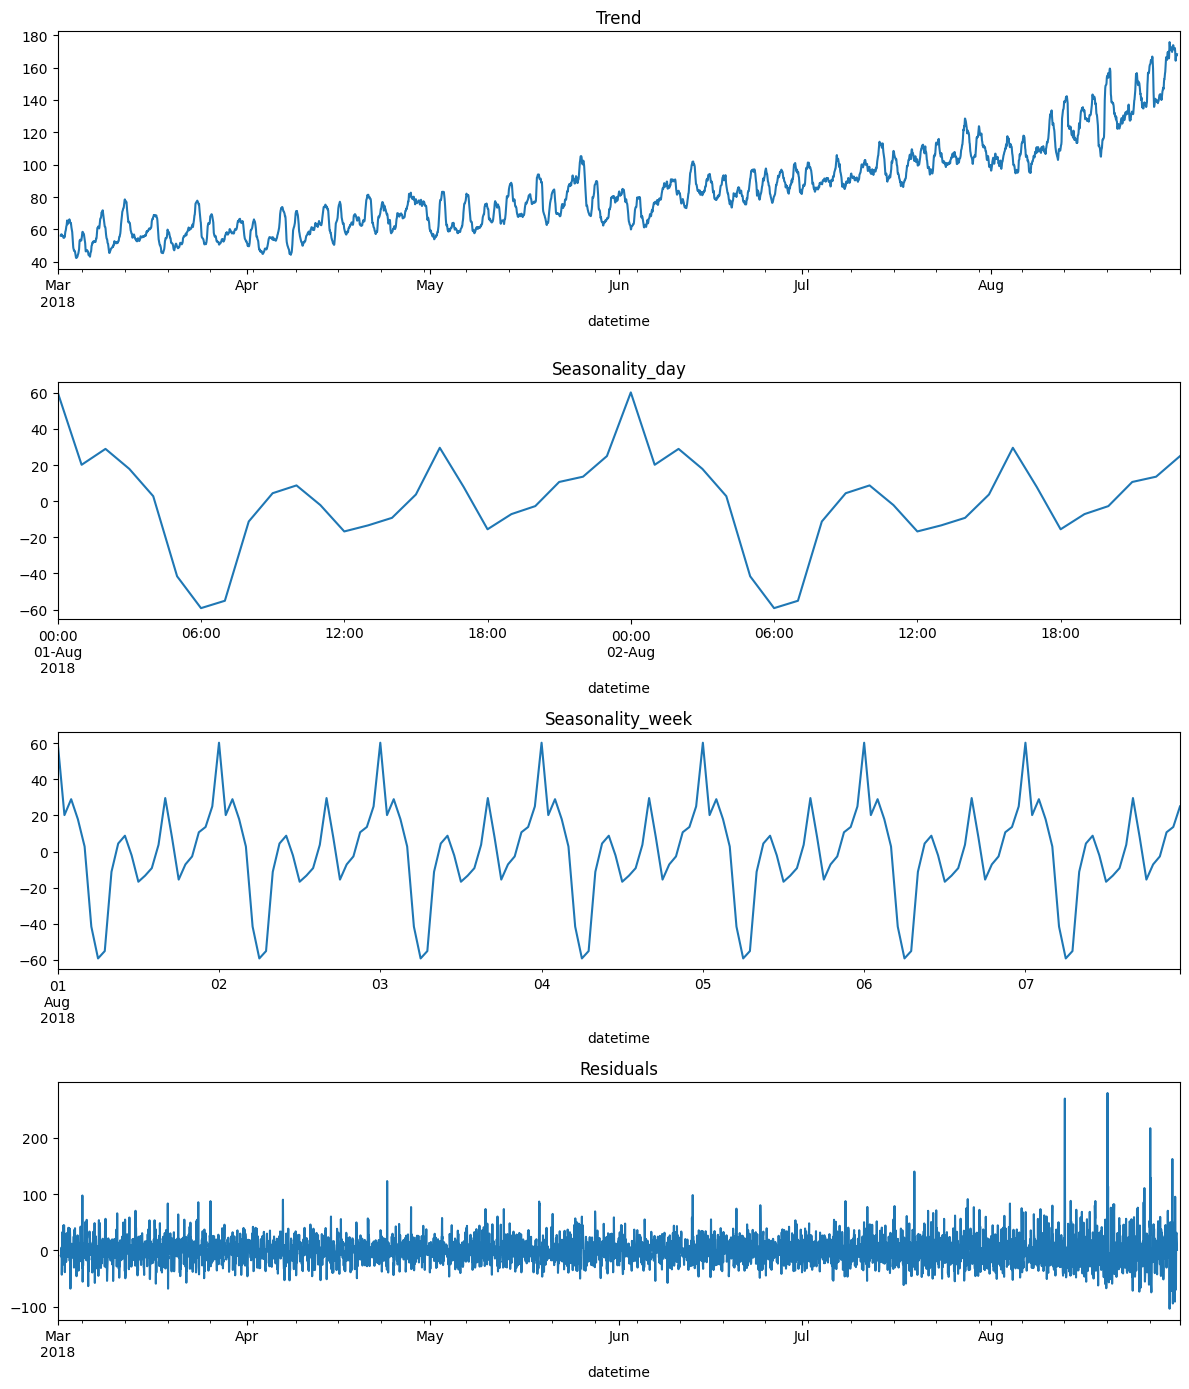

In [10]:
#разложим временой ряд
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 14))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(412)
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())
plt.title('Seasonality_day')
plt.subplot(413)
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca())
plt.title('Seasonality_week')  
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

In [11]:
#Функция создания признаков
def make_features(data, max_lag, rolling_mean_size):
    frame = data.copy()
    frame['dayofweek'] = frame.index.dayofweek
    frame['hour'] = frame.index.hour
    for lag in range(1, max_lag + 1):
        frame['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    frame['rolling_mean'] = frame['num_orders'].shift().rolling(rolling_mean_size).mean()
    return frame

In [12]:
frame = make_features(df, 24, 24)
frame

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


**Вывод:**

- временной ряд стационарный
- самый нагруженный день это пятница
- количество заказов к осени увеличивается
- пик заказов в 20:00-24:00, минимум заказов в 6 утра
- остатки необъяснимы

## Обучение

In [13]:
#разделим выборки на тренировочную и тестовую
train, test = train_test_split(frame, test_size=0.1, shuffle=False)
train = train.dropna()

In [14]:
#проверим выборки
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [15]:
#разделим на признаки и целевой признак
train_target = train['num_orders']
test_target = test['num_orders']

train_features = train.drop('num_orders', axis=1)
test_features = test.drop('num_orders', axis=1) 

# LinearRegression

In [16]:
%%time

tscv = TimeSeriesSplit(n_splits=5)
model_lr=LinearRegression()
model_lr.fit(train_features, train_target)
scores_lr = -cross_val_score(model_lr, 
                            train_features, 
                            train_target,
                            cv=tscv, 
                            scoring='neg_root_mean_squared_error') 
train_rmse_lr = np.mean(scores_lr)
print("RMSE обучающей выборки =", train_rmse_lr)

RMSE обучающей выборки = 27.133392250925603
CPU times: total: 125 ms
Wall time: 53.9 ms


In [17]:
importances_lr = pd.DataFrame(data={
    'Attribute': train_features.columns,
    'Importance': model_lr.coef_
})
importances_lr = importances_lr.sort_values(by='Importance', ascending=False)

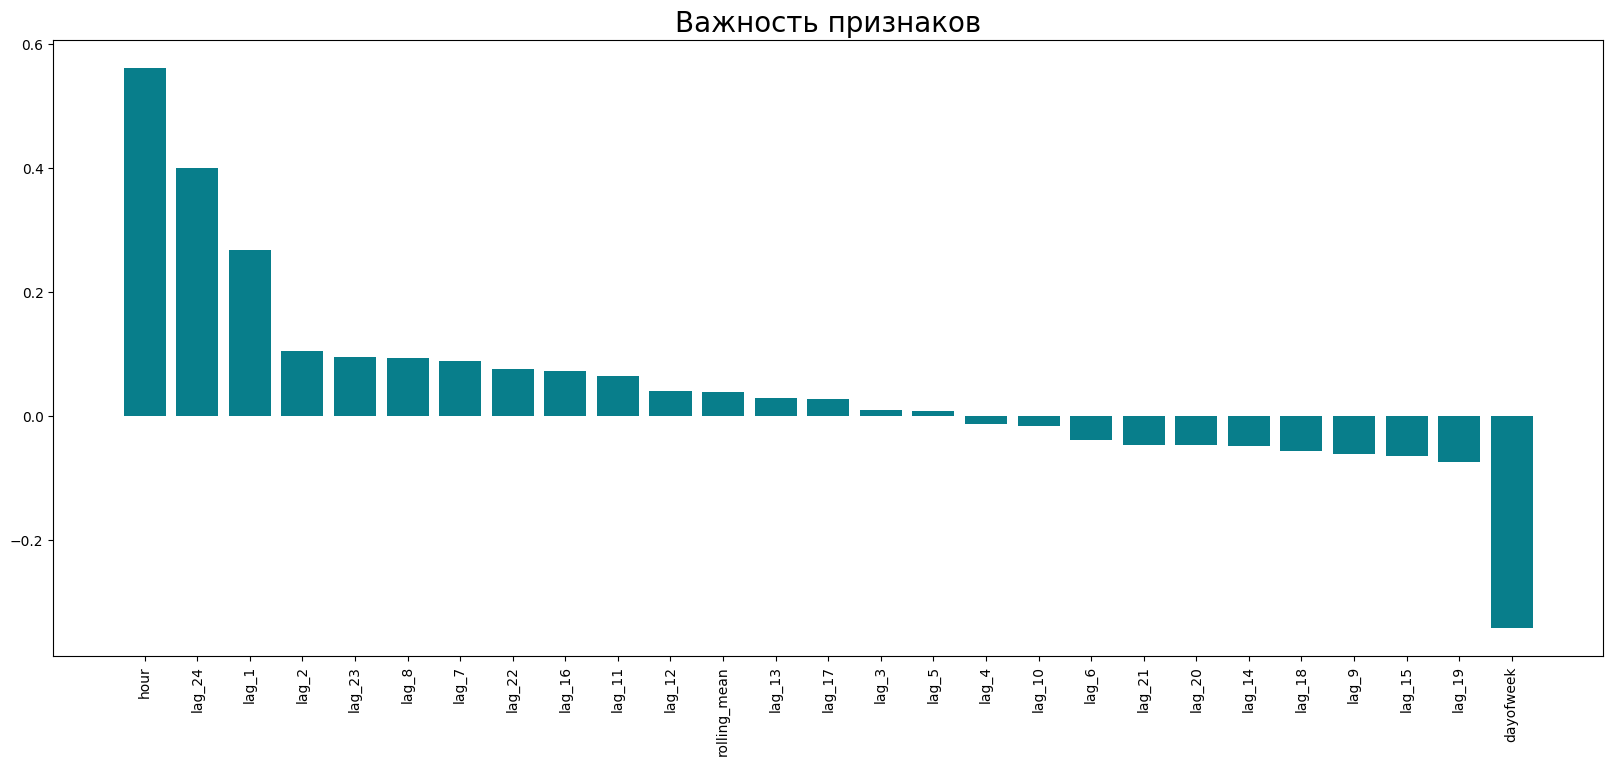

In [18]:
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(x=importances_lr['Attribute'], height=importances_lr['Importance'], color='#087E8B')
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.show()

# LGBMRegressor

In [19]:
%%time

tscv = TimeSeriesSplit(n_splits=5)
model_LGBMR = LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=12, learning_rate=0.2, n_estimators=100, random_state=12345)
model_LGBMR.fit(train_features, train_target)
scores_LGBMR = -cross_val_score(model_LGBMR, 
                            train_features, 
                            train_target,
                            cv=tscv, 
                            scoring='neg_root_mean_squared_error') 
train_rmse_LGBMR = np.mean(scores_LGBMR)
print("RMSE обучающей выборки =", train_rmse_LGBMR)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4836
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 27
[LightGBM] [Info] Start training from score 78.421013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_

In [20]:
importances_LGBMR = pd.DataFrame(data={
    'Attribute': train_features.columns,
    'Importance': model_LGBMR.feature_importances_
})
importances_LGBMR = importances_LGBMR.sort_values(by='Importance', ascending=False)

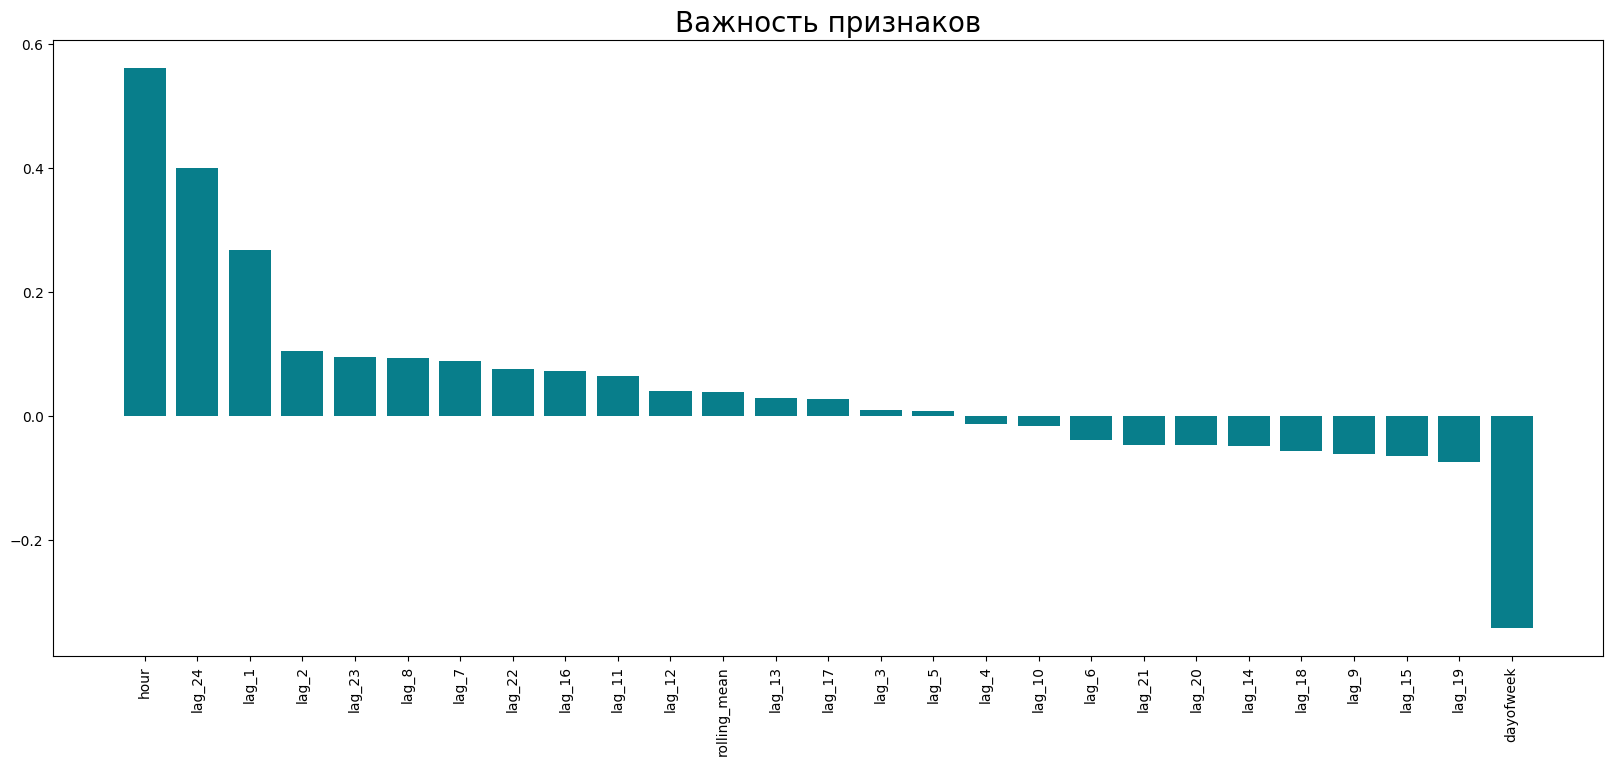

In [21]:
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(x=importances_lr['Attribute'], height=importances_lr['Importance'], color='#087E8B')
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.show()

# CatBoostRegressor

In [22]:
%%time

tscv = TimeSeriesSplit(n_splits=5)
model_cbr = CatBoostRegressor(loss_function='RMSE', n_estimators = 100, silent = True)
model_cbr.fit(train_features, train_target)
scores_cbr = -cross_val_score(model_cbr, 
                            train_features, 
                            train_target,
                            cv=tscv, 
                            scoring='neg_root_mean_squared_error') 
train_rmse_cbr = np.mean(scores_cbr)
print("RMSE обучающей выборки =", train_rmse_cbr) 

RMSE обучающей выборки = 24.737448034056154
CPU times: total: 12.2 s
Wall time: 1.73 s


In [23]:
importances_cbr = pd.DataFrame(data={
    'Attribute': train_features.columns,
    'Importance': model_cbr.feature_importances_
})
importances_cbr = importances_cbr.sort_values(by='Importance', ascending=False)

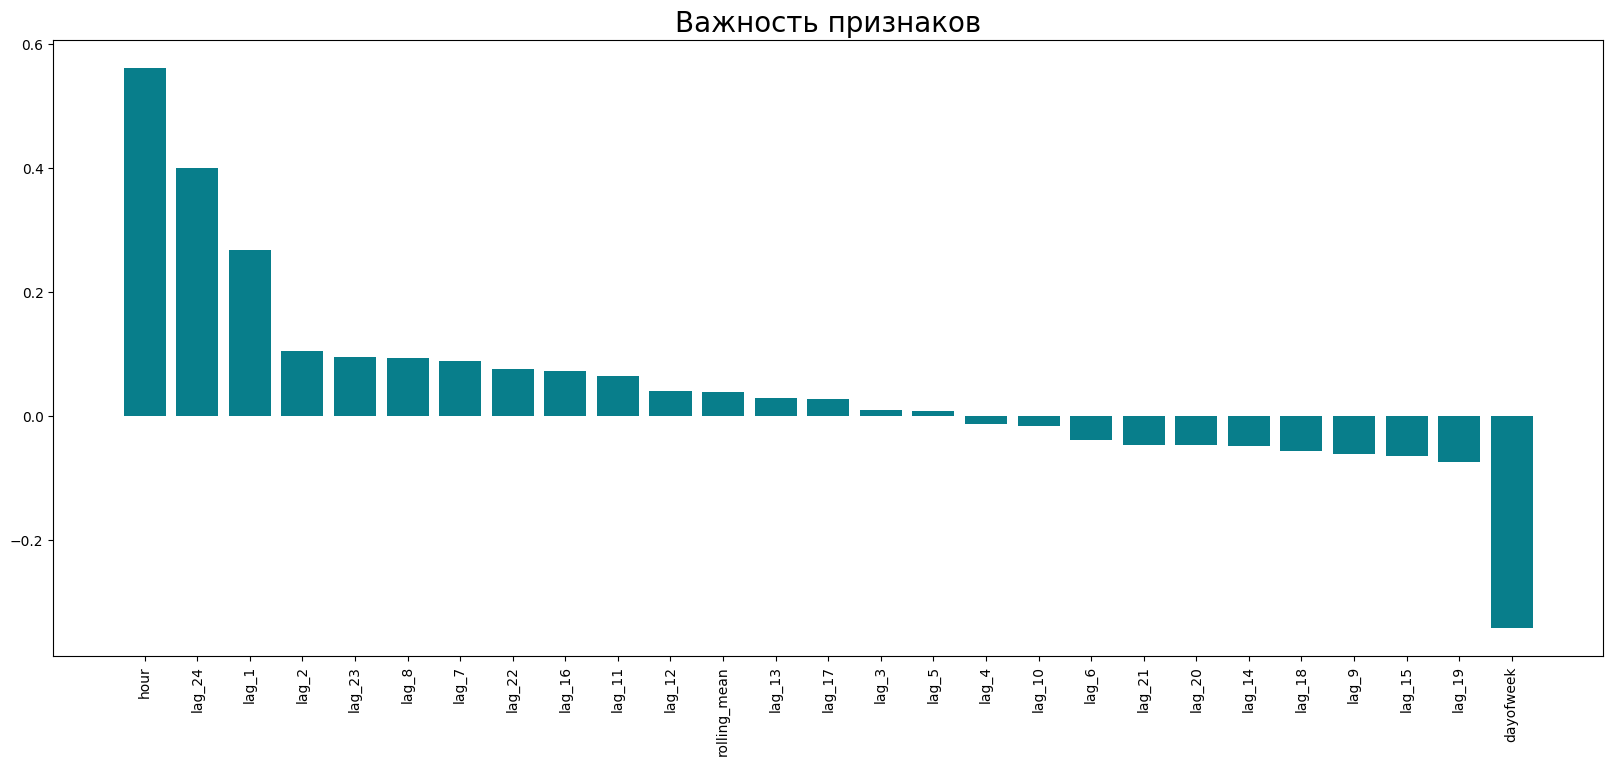

In [24]:
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(x=importances_lr['Attribute'], height=importances_lr['Importance'], color='#087E8B')
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.show()

**Вывод:**

Наименьшее значение RMSE получилось у модели `CatBoostRegressor` равное 24.74, ее и будем тестировать

## Тестирование

In [25]:
test_scores_cbr = -cross_val_score(model_cbr, 
                            test_features, 
                            test_target,
                            cv=5, 
                            scoring='neg_root_mean_squared_error') 
test_rmse_cbr = np.mean(test_scores_cbr)
print("RMSE тестовой выборки =", test_rmse_cbr)
#прогноз модели по прошлом ряду
pred_previous = np.ones(test_target.shape) * train_target.iloc[-1]
print("RMSE for Constant Model:", np.sqrt(mean_squared_error(test_target, pred_previous)))

RMSE тестовой выборки = 40.82418827166889
RMSE for Constant Model: 62.05343632125475


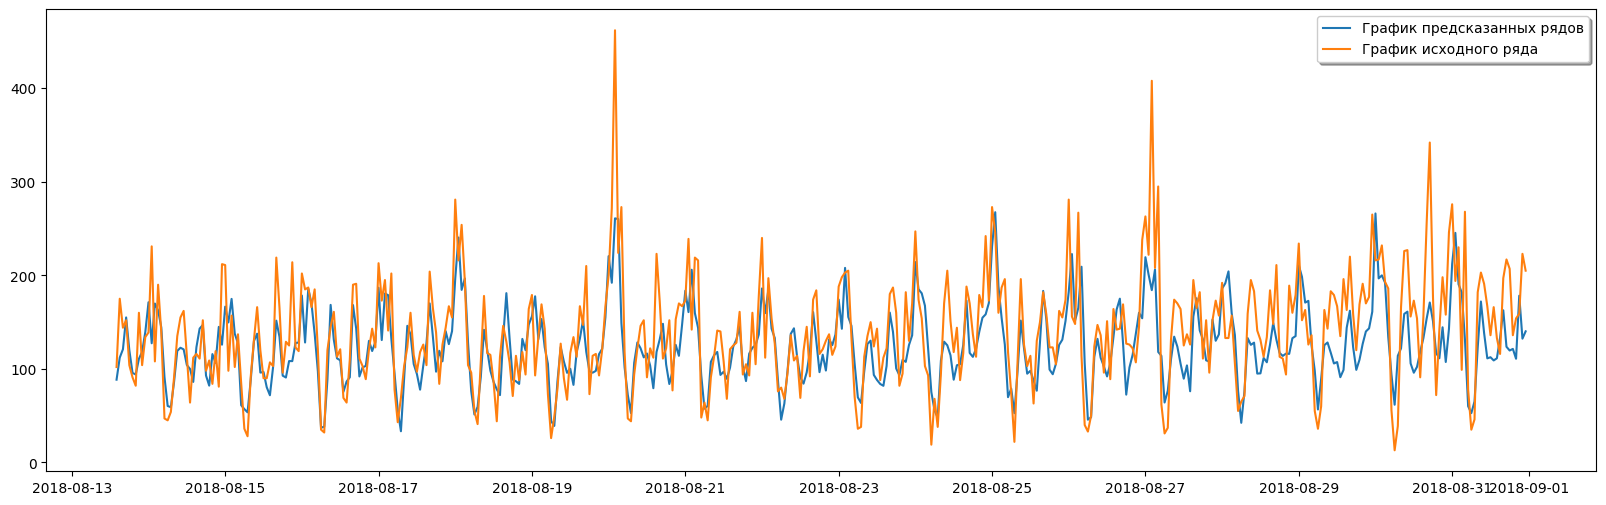

In [26]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(pd.Series(model_cbr.predict(test_features), index = test_target.index), label='График предсказанных рядов')
ax.plot(test_target, label='График исходного ряда')
legend = ax.legend(loc='upper right', shadow=True, fontsize= 10)

**Вывод:**

Получили RMSE модели CatBoost на тестовой выборки = 39.41. Модель хорошо предсказываем минимальные значения заказов, пиковые значения предсказывает хуже

**Общий вывод:**

- Загрузили данные, выполнили их ресемплирование по одному часу
- Проанализировали данные
- Обучили три модели: Линейную регрессию, LightGBM, Catboost
- Проверили данные на тестовой выборке
- Выбрали лучшую модель, у которой значение RMSE на тестовой выборке не больше 48

 Лучшей моделью оказалась `CatBoost`:
- RMSE = 39.41